# EchoPro Transect Subset Workflow

## Import libraries and configure the Jupyter notebook

In [1]:
# libraries used in the Notebook
import matplotlib.pyplot as plt
import math 
import numpy as np 

# Python version of EchoPro
import EchoPro

# Allows us to grab the SemiVariogram class so we can use its models
from EchoPro.computation import SemiVariogram as SV

# obtain all visualization routines
from EchoPro.visualization import plot_layered_points, plot_kriging_results

# Allows us to easily use matplotlib widgets in our Notebook
# %matplotlib widget

## Set up  EchoPro for a specific survey year

### Initialize EchoPro object  using configuration files

* `initialization_config.yml` -- parameters independent of survey year
* `survey_year_2019_config.yml` -- parameters specific to survey year
* `source` -- Define the region of data to use e.g. US, CAN, US & CAN
* `exclude_age1` -- States whether age 1 hake should be included in analysis.

In [2]:
%%time
survey_2019 = EchoPro.Survey(init_file_path='../config_files/initialization_config.yml',
                             survey_year_file_path='../config_files/survey_year_2019_config.yml',
                             source=3, 
                             exclude_age1=True)

A full check of the initialization file contents needs to be done!
A check of the survey year file contents needs to be done!
CPU times: user 4.93 ms, sys: 445 µs, total: 5.37 ms
Wall time: 5.58 ms


### Load and process input data 
* This data is stored in `survey_2019`

In [3]:
%%time 
survey_2019.load_survey_data()

CPU times: user 1.19 s, sys: 12.8 ms, total: 1.21 s
Wall time: 1.2 s


In [4]:
survey_2019.nasc_df.head()

,vessel_log_start,vessel_log_end,latitude,longitude,stratum_num,transect_spacing,NASC,haul_num
transect_num,,,,,,,,
1,744.016009,744.491145,34.397267,-121.143005,1,10.0,0.0,0
1,744.500276,744.995605,34.397391,-121.133196,1,10.0,0.0,0
1,745.004125,745.499447,34.397435,-121.123057,1,10.0,0.0,0
1,745.508199,745.994306,34.397394,-121.112871,1,10.0,0.0,0
1,746.003214,746.495701,34.397437,-121.102888,1,10.0,0.0,0


### Select a subset of the available transects to analyze

In [5]:
# obtain all unique transects in nasc_df
unique_transects = survey_2019.nasc_df.index.unique().values

In [6]:
# set the percentage of transects that should be removed
removal_percentage = 50.0

# determine the number of transects that should be selected
num_sel_transects = math.floor(len(unique_transects) * (1.0 - removal_percentage / 100.0))

# initialize the random number generator object and fix the seed
rng = np.random.default_rng(seed=1234)

# randomly select transects without replacement
selected_transects = list(rng.choice(unique_transects, num_sel_transects, replace=False))

### Compute the areal biomass density on subset of transects
* The areal biomass density is stored in `survey_2019.bio_calc.transect_results_gdf` as `biomass_density_adult`

In [7]:
%%time
survey_2019.compute_biomass_density(selected_transects=selected_transects)

CPU times: user 104 ms, sys: 7 µs, total: 104 ms
Wall time: 104 ms


In [8]:
survey_2019.bio_calc.transect_results_gdf.head()

,latitude,longitude,stratum_num,transect_spacing,biomass_density_adult,interval_area_nmi2,biomass,geometry
transect_num,,,,,,,,
5,35.065000,-120.726321,1,9.99037,0.0,3.928483,0.0,POINT (-120.72632 35.06500)
5,35.064833,-120.734500,1,9.99037,0.0,5.039252,0.0,POINT (-120.73450 35.06483)
5,35.064667,-120.744833,1,9.99037,0.0,4.975134,0.0,POINT (-120.74483 35.06467)
5,35.064333,-120.754879,1,9.99037,0.0,5.025835,0.0,POINT (-120.75488 35.06433)
5,35.063833,-120.765167,1,9.99037,0.0,4.951517,0.0,POINT (-120.76517 35.06383)


In [9]:
print(f"Total Biomass Estimate without Kriging: {1e-6*survey_2019.bio_calc.transect_results_gdf.biomass.sum():.3f} kmt")

Total Biomass Estimate without Kriging: 482.380 kmt


**Note:**

**After the biomass density has been calculated using the selected transects, all steps that we have previously ran can be completed. However, it is important to note that it is suggested that one computes the semi-variogram parameters using the full data set, rather than a subset of transects. To remind the user of this, a warning will be raised if the user chooses to run the semi-variogram routine (we will demonstrate this later).** 

## Jolly-Hampton CV Analysis

* Compute the mean of the Jolly-Hampton CV value on data that has not been Kriged
* Note: the algorithm used to compute this value is random in nature

In [10]:
%%time
CV_JH_mean = survey_2019.run_cv_analysis(kriged_data=False)

CPU times: user 1.07 s, sys: 8.31 ms, total: 1.08 s
Wall time: 1.08 s


In [11]:
print(f"Mean Jolly-Hampton CV: {CV_JH_mean:.4f}")

Mean Jolly-Hampton CV: 0.2595


## Obtain Kriging Mesh Data

### Access Kriging mesh object
* Reads mesh data files specified by `survey_2019` 

In [12]:
krig_mesh = survey_2019.get_kriging_mesh()

#### Plot the Mesh, Transects and smoothed isobath contour

* Generate interactive map using the Folium package
* Mesh points are in gray
* Transect points are represented by a changing color gradient
* Smoothed contour points (200m isobath) are in blue 

In [13]:
fmap = plot_layered_points(krig_mesh, plot_mesh_points=False)
fmap

## Apply coordinate transformations
* Longitude transformation
* Lat/Lon to distance

### Transect points

In [14]:
krig_mesh.apply_coordinate_transformation(coord_type='transect')

### Mesh points

In [15]:
krig_mesh.apply_coordinate_transformation(coord_type='mesh')

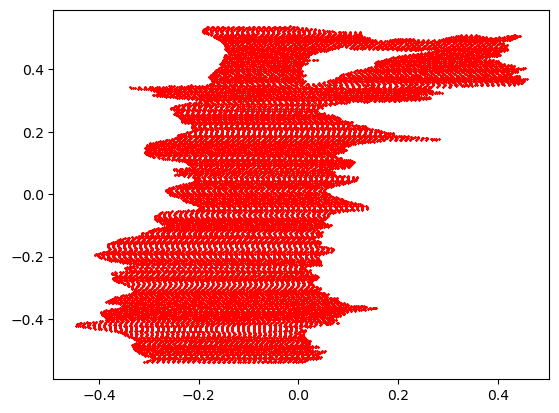

In [16]:
# plot the transformed mesh points 
plt.plot(krig_mesh.transformed_mesh_df.x_mesh, 
         krig_mesh.transformed_mesh_df.y_mesh, 'r*', markersize=1.25)
plt.show()

## Try to initialize the Semi-Variogram

In [17]:
semi_vario = survey_2019.get_semi_variogram(
    krig_mesh,
    params=dict(nlag=30, lag_res=0.002)
)

/usr/mayorgadat/workmain/acoustics/gh/uw-echospace/EchoPro/EchoPro/survey.py:474: UserWarning: The biomass data being used is a subset of the full dataset. It is recommended that you use the biomass data created from the full dataset. To silence this warning set the warning argument to False.
  warn(


**As expected, a warning pops up and reminds us not to run the semi-variogram calculation and model fitting using the data that was generated from a subset of the full data set.**

## Perform Ordinary Kriging of areal biomass density

* transformed mesh points
* semi-variogram model
* areal biomass density

### Initialize Kriging routine

In [18]:
kriging_params = dict(
    # kriging parameters
    k_max=10,
    k_min=3,
    R=0.0226287,
    ratio=0.001,
    
    # parameters for semi-variogram model
    s_v_params={'nugget': 0.0, 'sill': 0.95279, 'ls': 0.0075429,
                'exp_pow': 1.5, 'ls_hole_eff': 0.0},
    
    # grab appropriate semi-variogram model
    s_v_model=SV.generalized_exp_bessel
)

# initalize kriging routine
krig = survey_2019.get_kriging(kriging_params)

### Perform Kriging
* Also generates total biomass at mesh points

In [19]:
%%time
krig.run_biomass_kriging(krig_mesh)

CPU times: user 2.86 s, sys: 863 ms, total: 3.72 s
Wall time: 2.08 s


In [20]:
krig_results = survey_2019.bio_calc.kriging_results_gdf

Convert from kg to kmt

In [21]:
krig_results.biomass = 1e-6 * krig_results.biomass

In [22]:
print(f"Total Kriged Biomass Estimate: {krig_results.biomass.sum():.3f} kmt")

Total Kriged Biomass Estimate: 1060.860 kmt


### Plot Kriged Biomass estimate in kmt

In [23]:
# plot mesh points with biomass values > 0
plot_kriging_results(krig_results, krig_field_name="biomass", greater_than_0=True)